# Coursework Template

**Dependencies and imports**

This can take a minute...

In [1]:
# !pip install swig
# !pip install --upgrade rldurham

In [2]:
import torch
import rldurham as rld

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [3]:
class Agent(torch.nn.Module):
    def __init__(self):
        super(Agent, self).__init__()

    def sample_action(self, s):
        return torch.rand(act_dim) * 2 - 1 # unifrom random in [-1, 1]

    def put_data(self, action, observation, reward):
        pass

    def train(self):
        pass

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cuda (train on the cpu is recommended instead)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


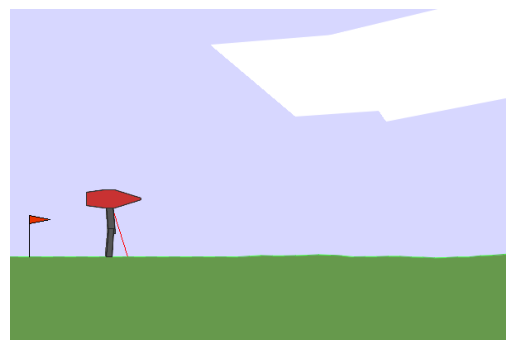

In [4]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved WalkerEasy

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

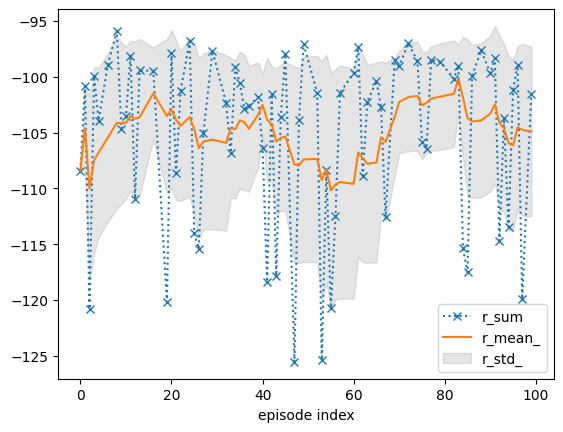

In [5]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent()
max_episodes = 100
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    # env.info = episode % 10 == 0   # track every x episodes (usually tracking every episode is fine)
    # env.video = episode % 10 == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()

    # run episode
    for t in range(max_timesteps):
        
        # select the agent action
        action = agent.sample_action(observation)

        # take action in the environment
        observation, reward, terminated, truncated, info = env.step(action)

        # remember
        agent.put_data(action, observation, reward)

        # check whether done
        done = terminated or truncated

        # stop episode
        if done:
            break

    # TRAIN THE AGENT HERE!
            
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [6]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
